In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yahist
import mplhep as hep

from utils.analysis import Validation

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

TAG = "kscans"
APPLY_EWKFIX = True

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "VBSWH_mkW" not in baby and "Lambda" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
babies

['../analysis/studies/vbswh/output_kscans/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_kscans/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTX.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VH.root',
 '../analysis/studies/vbswh/output_kscans/Run2/WJets.root',
 '../analysis/studies/vbswh/output_kscans/Run2/data.root',
 '../analysis/studies/vbswh/output_kscans/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_SM.root']

In [3]:
# babies.remove("../analysis/studies/vbswh/output_ewkcheck_nofix/Run2/EWKWLep.root")
# babies.remove("../analysis/studies/vbswh/output_ewkcheck_nofix/Run2/EWKVOther.root")

In [4]:
if APPLY_EWKFIX:
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf"
    ]
    plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/val"
else:
    weight_columns=[
        "xsec_sf", "lep_id_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf"
    ]
    plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}_nofix/val"

In [5]:
vbswh = Validation(
    bkg_root_files=[baby for baby in babies if "data" not in baby],
    data_root_files=[baby for baby in babies if "data" in baby],
    ttree_name="tree",
    weight_columns=weight_columns,
    plots_dir=plots_dir,
    sample_labels = {
        "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights"
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)

vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection(
#     "M_jj > 1500 and abs(deta_jj) > 4 and passes_bveto and ST > 1200 and hbbjet_msoftdrop > 150 and hbbjet_score < 0.9"
# )
# vbswh.make_selection(
#     "passes_bveto and hbbjet_score < 0.9"
# )
# vbswh.make_selection("passes_bveto != True")

Loading data babies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_msoftdrop_data_vs_mc_(regionA_or_(presel_noDetaJJ_and_M_jj_gt_600_and_ST_gt_900_and_hbbjet_score_gt_0p9_and_abs(deta_jj)_gt_4_and_hbbjet_msoftdrop_lt_150)).pdf


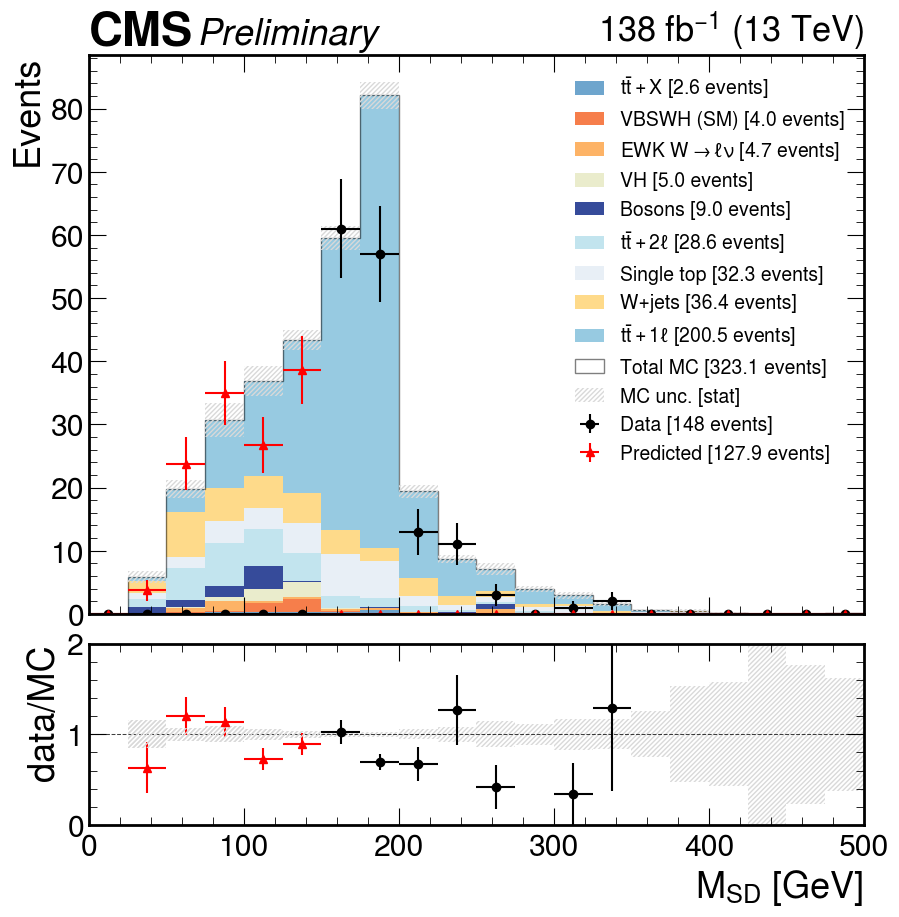

In [6]:
column = "hbbjet_msoftdrop"
bins = np.linspace(0, 500, 21)
x_label = r"$M_{SD}$ [GeV]"

BtoA = vbswh.data_count(selection="regionA")/vbswh.data_count(selection="regionB")

regionD = "(presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150)"

hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    column, 
    bins=bins, 
    selection=f"(regionA or {regionD})",
    x_label=x_label,
    stacked=True,
    blinded_range=(0, 150),
    blinded_box=False
)

# Get numerator (data) and denominator (bkg MC)
denom_df = vbswh.bkg_df(selection=f"{regionD}")
denom = yahist.Hist1D(
    denom_df[column],
    bins=np.linspace(0, 500, 21),
    weights=denom_df.event_weight,
);
numer_df = vbswh.data_df(selection="regionC")
numer = yahist.Hist1D(
    numer_df[column],
    bins=np.linspace(0, 500, 21),
    weights=numer_df.event_weight*BtoA,
    label=f"Predicted [{len(numer_df)*BtoA:.1f} events]",
    color="r"
);
    
# Get ratio
ratio = numer/denom
# Set ratio errors to data relative stat error times the ratio
numer_counts = numer.counts
numer_counts[numer_counts == 0] = 1e-12
ratio._errors = (numer.errors/numer_counts)*ratio.counts

# Plot hists and ratio
numer.plot(ax=hist_axes, errors=True, fmt="^")
ratio.plot(ax=ratio_axes, errors=True, fmt="^")

# Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
denom_counts = denom.counts
denom_counts[denom_counts == 0] = 1e-12
err_points = np.repeat(denom.edges, 2)[1:-1]
err_high = np.repeat(1 + denom.errors/denom_counts, 2)
err_low = np.repeat(1 - denom.errors/denom_counts, 2)
ratio_axes.fill_between(
    err_points, err_high, err_low,
    step="mid",
    hatch="///////",
    facecolor="none",
    edgecolor=(0.85, 0.85, 0.85),
    linewidth=0.0,
    linestyle="-",
    zorder=2
)

hist_axes.legend(fontsize=14)

ratio_axes.set_ylim([0., 2.0])
ratio_axes.legend().remove()

plt.savefig(f"{plots_dir}/regionsAD_closure.pdf")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_msoftdrop_data_vs_mc_(regionB_or_regionC).pdf


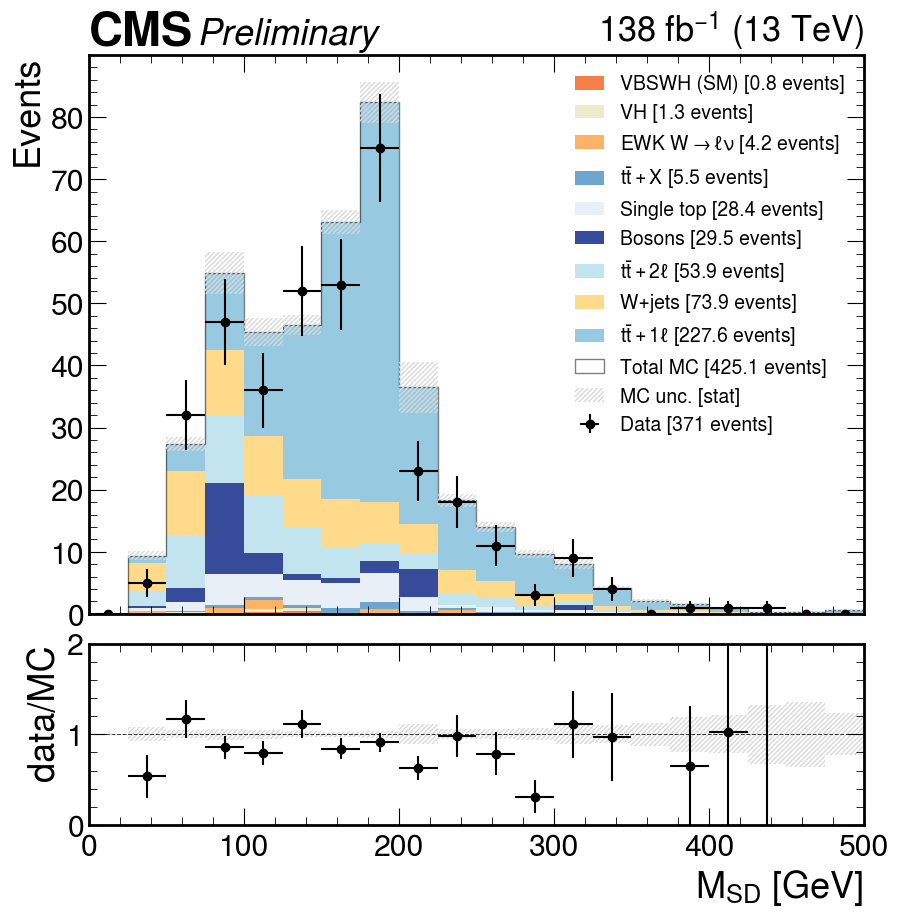

In [7]:
hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", 
    bins=np.linspace(0, 500, 21), 
    selection="(regionB or regionC)",
#     blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
    x_label=r"$M_{SD}$ [GeV]",
#     norm=True,
    stacked=True
)

ratio_axes.set_ylim([0., 2.0])
plt.savefig(f"{plots_dir}/regionsBC_closure.pdf")

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_score_data_vs_mc_presel_noDetaJJ_and_abs(deta_jj)_leq_3.pdf


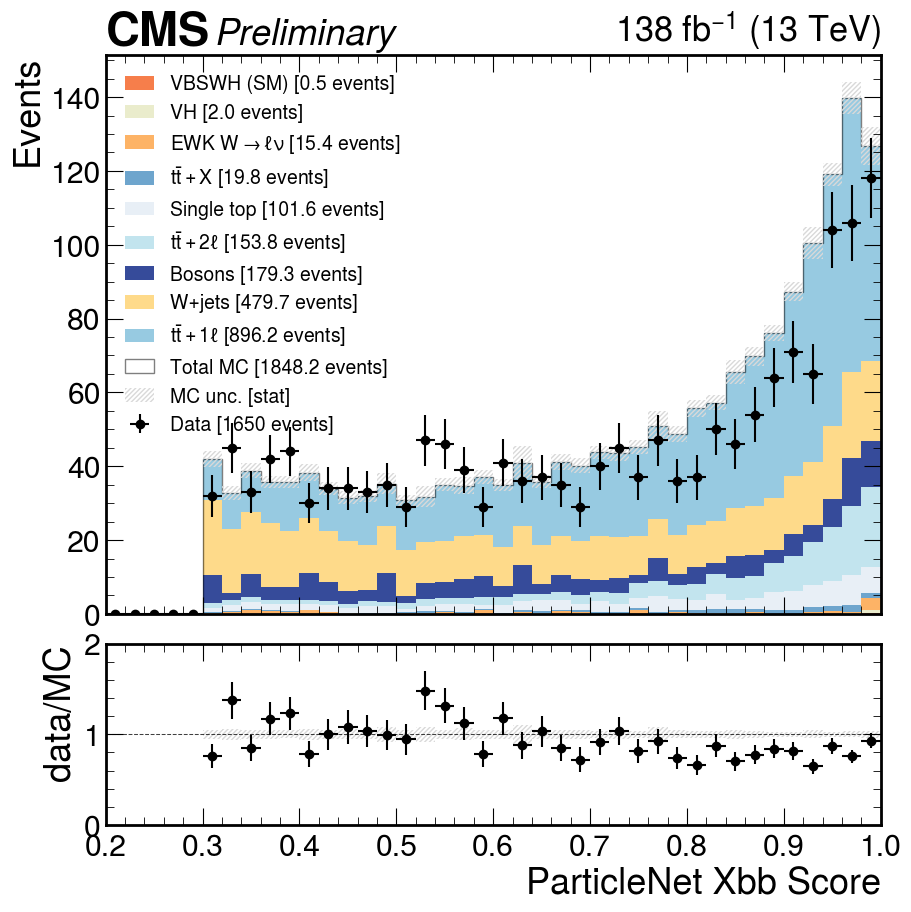

In [8]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ and abs(deta_jj) <= 3",
    x_label="ParticleNet Xbb Score",
    stacked=True
);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_msoftdrop_data_vs_mc_presel_noDetaJJ_and_abs(deta_jj)_leq_3.pdf


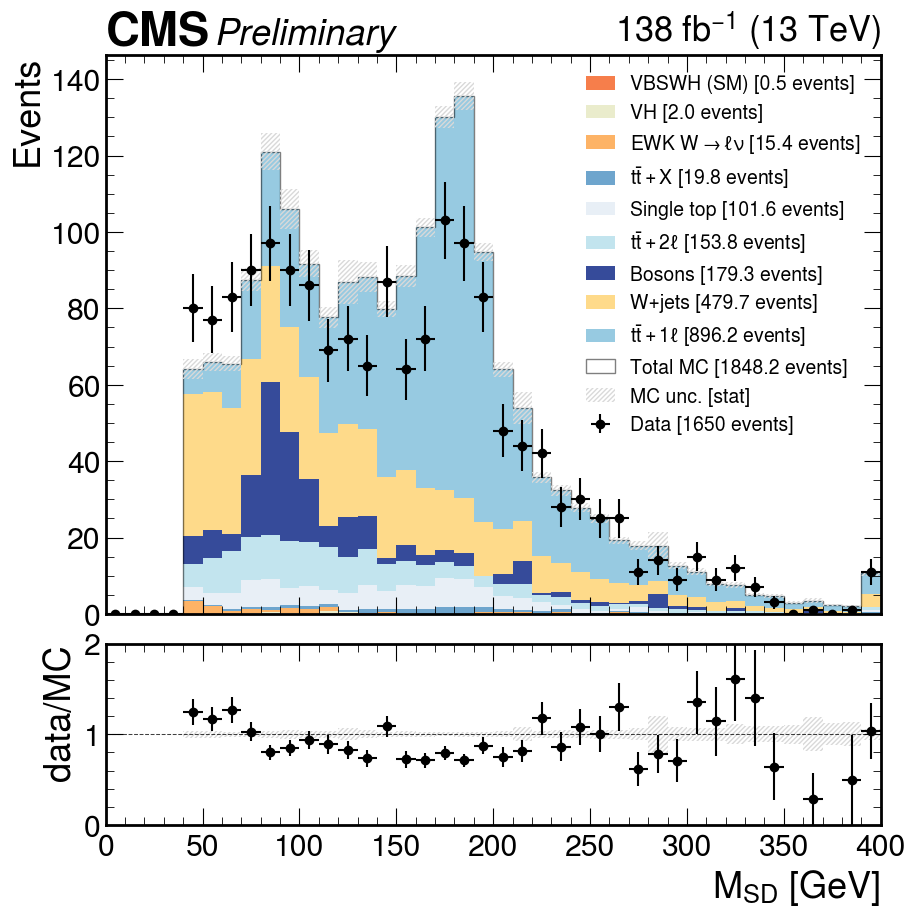

In [9]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ and abs(deta_jj) <= 3",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_regionB_and_ST_gt_1500.pdf


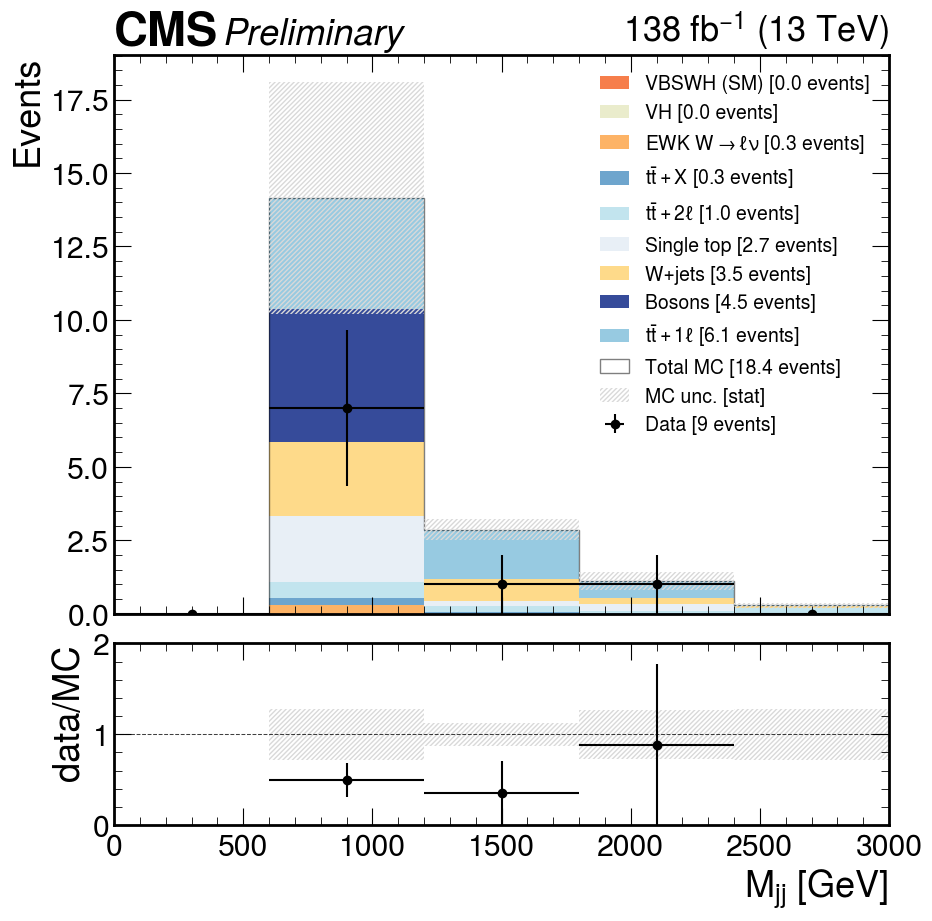

In [10]:
hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(0, 3000, 6), 
    selection="regionB and ST > 1500",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/ST_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/ST_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/ST_data_vs_mc_regionC.pdf


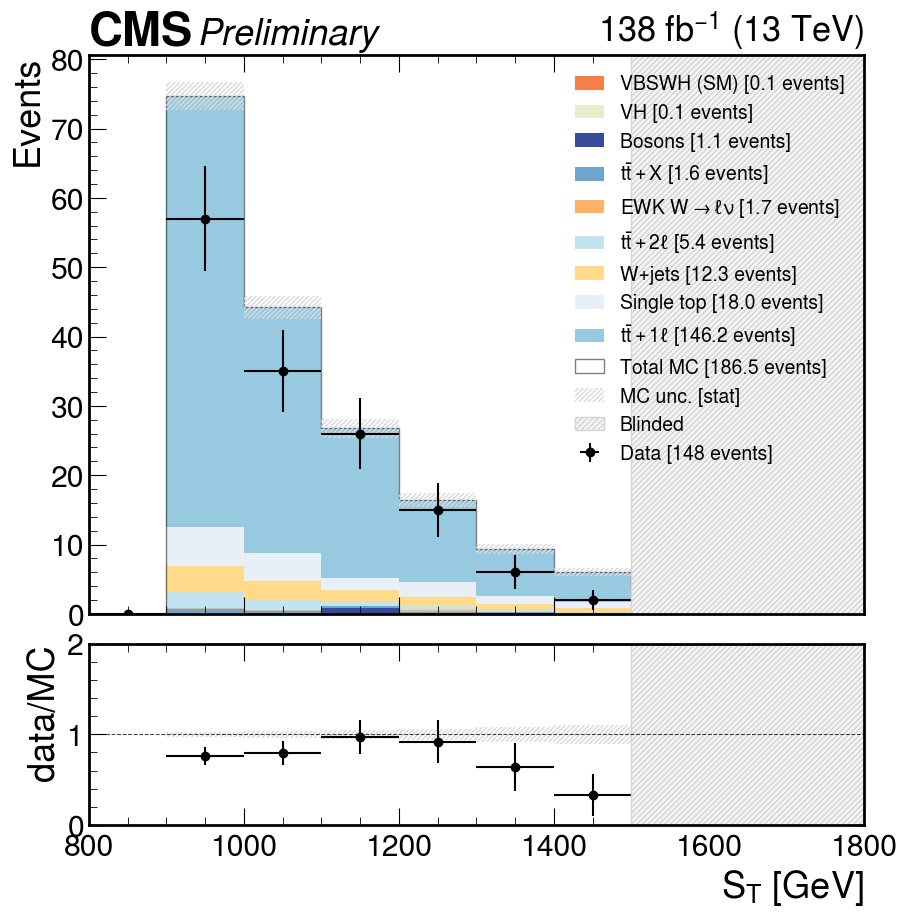

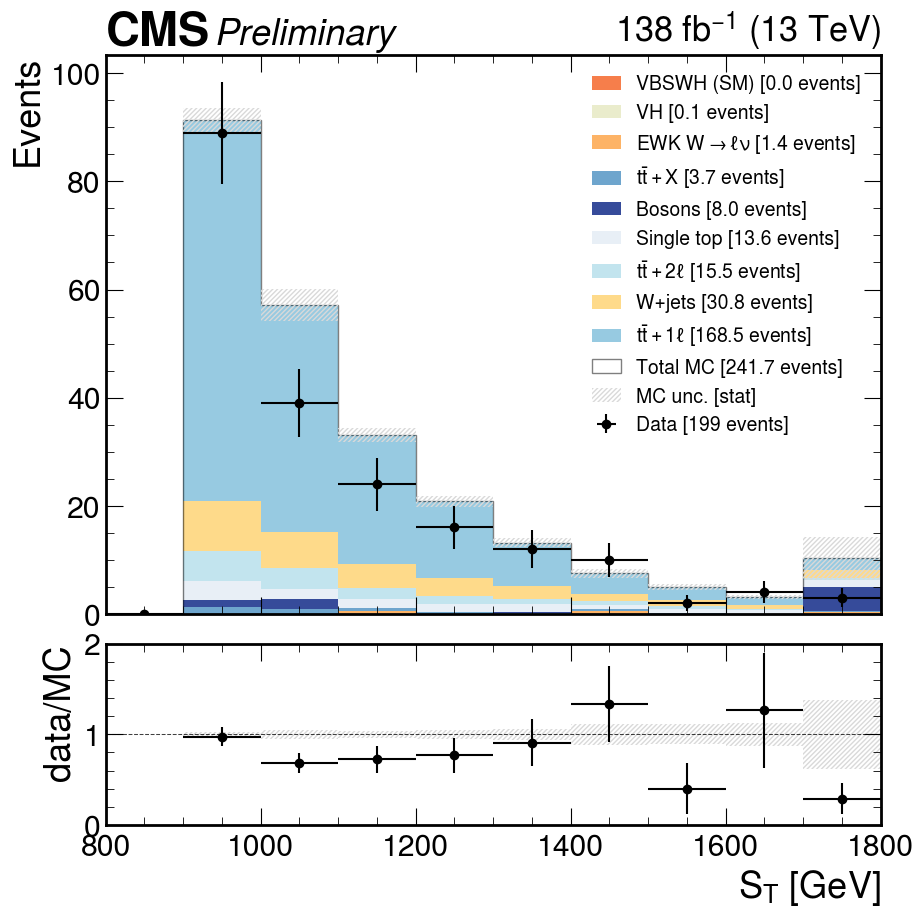

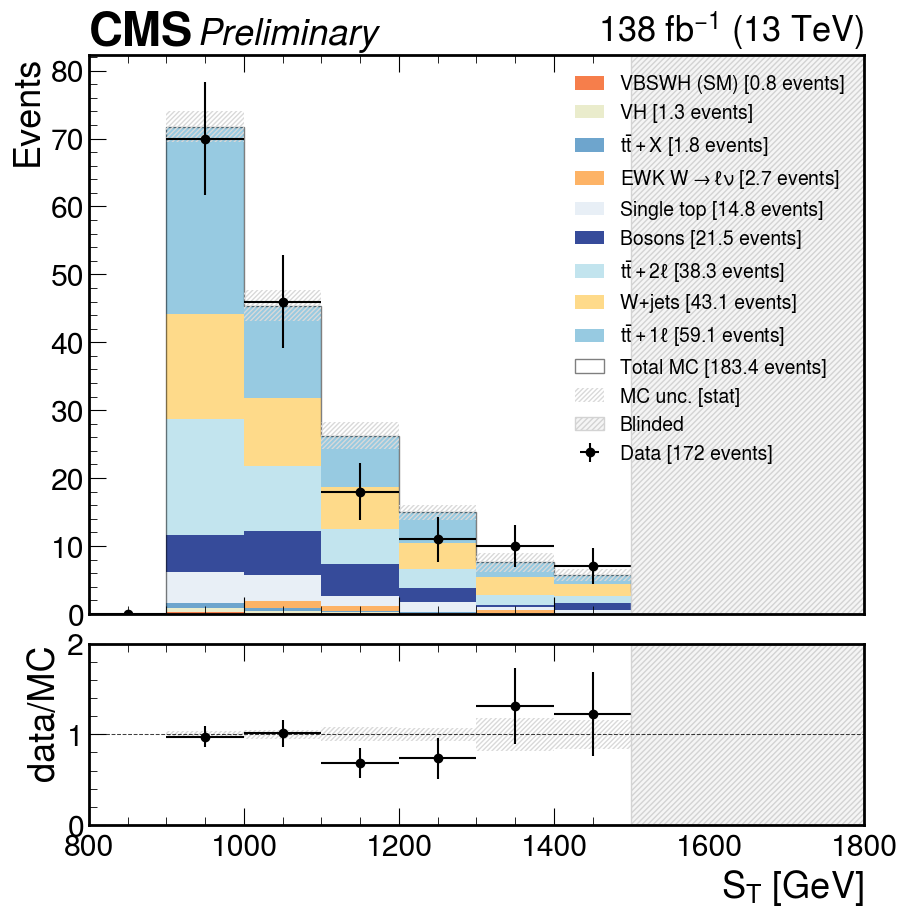

In [11]:
for selection in ["regionA", "regionB", "regionC"]:
    hist_axes, ratio_axes = vbswh.plot_data_vs_mc(
        "ST", 
        bins=np.linspace(800, 1800, 11), 
        selection=f"{selection}",
        blinded_range=(1500, 1800) if selection == "regionC" or selection == "regionA" else None,
        x_label=r"$S_T$ [GeV]",
        stacked=True,
        legend_loc="upper right"
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_regionC.pdf


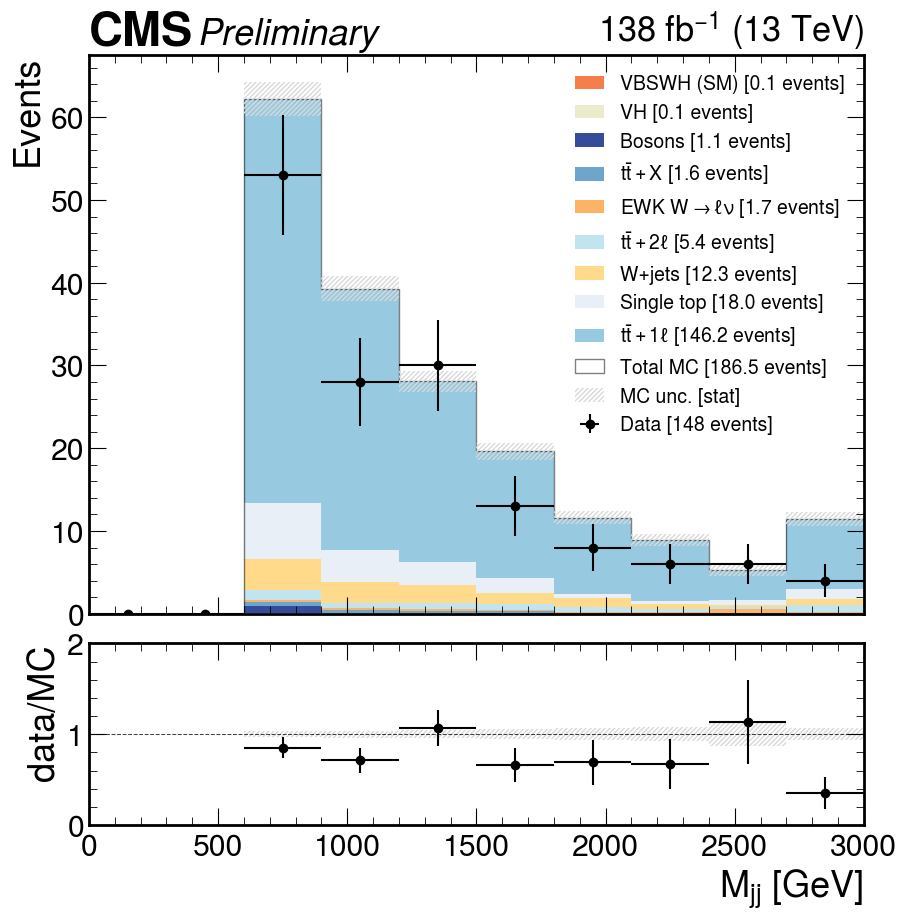

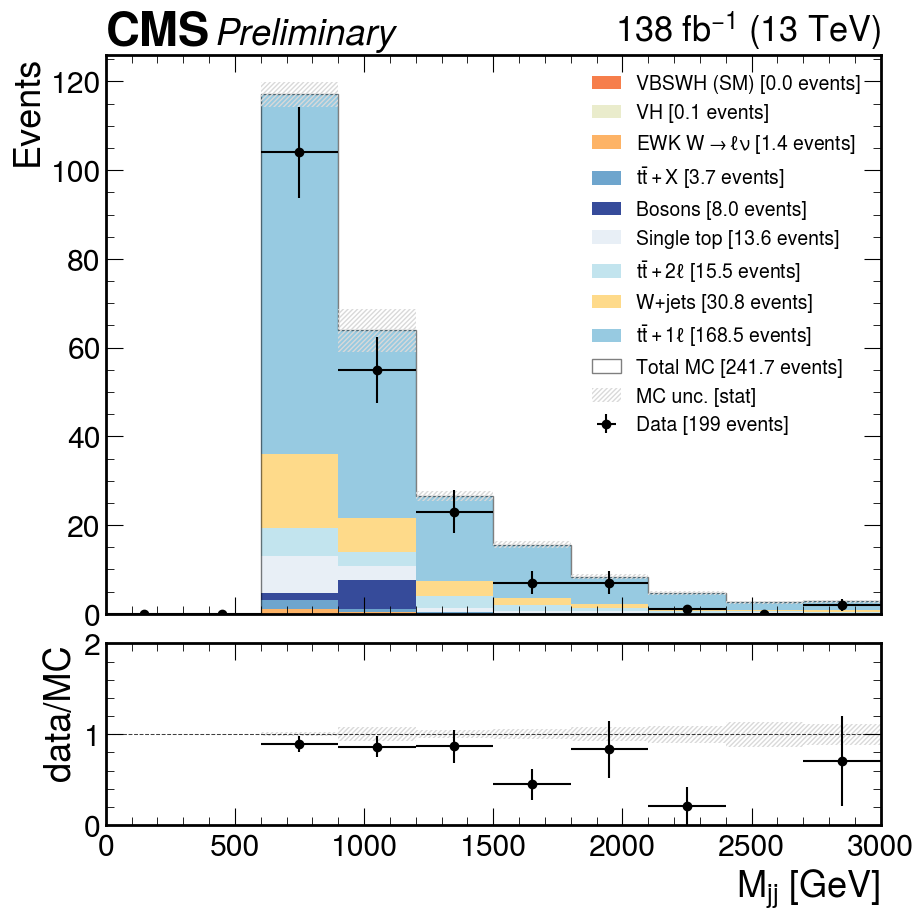

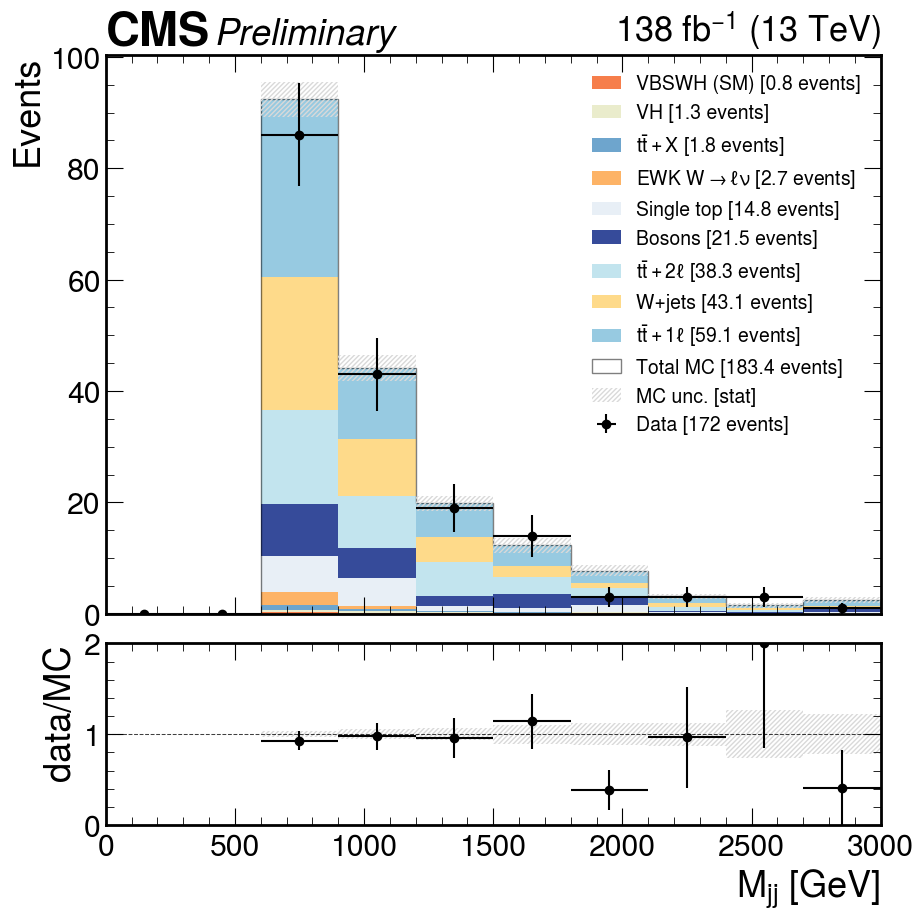

In [12]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "M_jj", bins=np.linspace(0, 3000, 11), 
        selection=selection,
        x_label=r"$M_{jj}$ [GeV]",
    #     norm=True,
        stacked=True
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/deta_jj_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/deta_jj_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/deta_jj_data_vs_mc_regionC.pdf


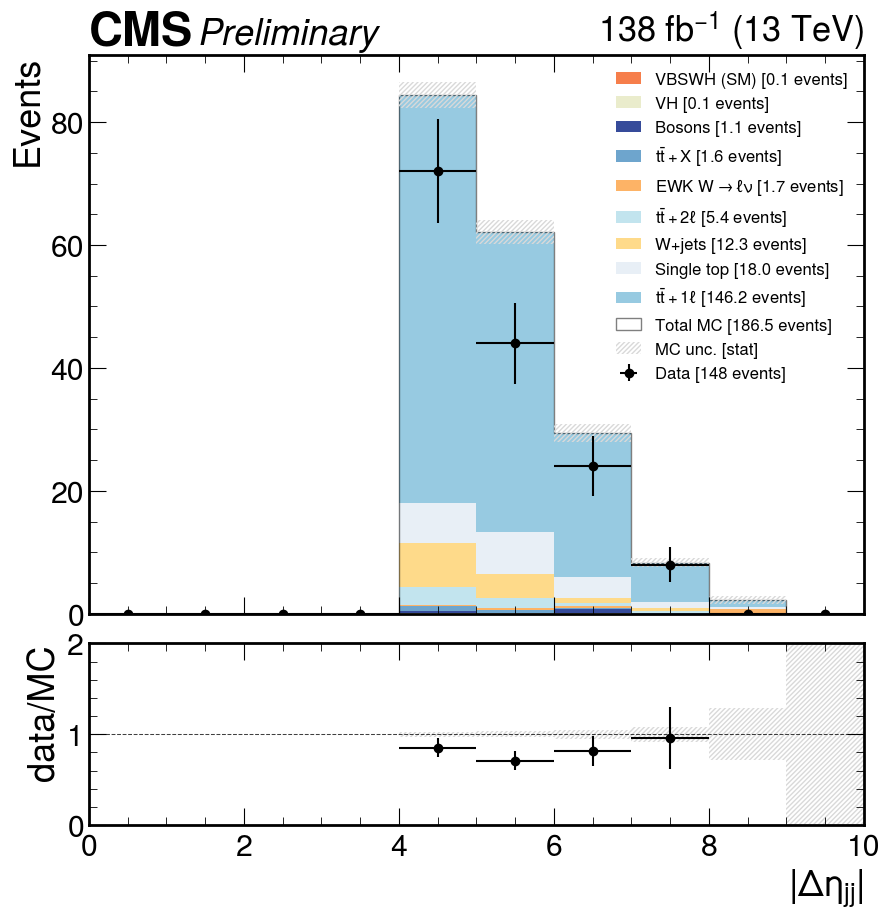

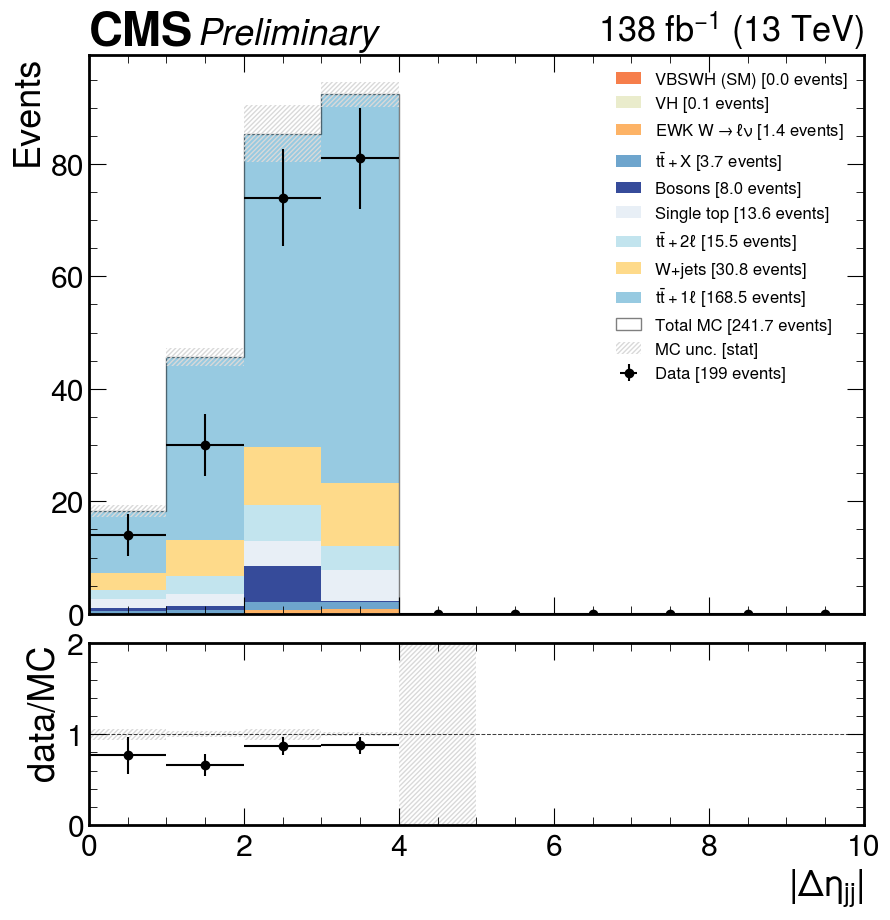

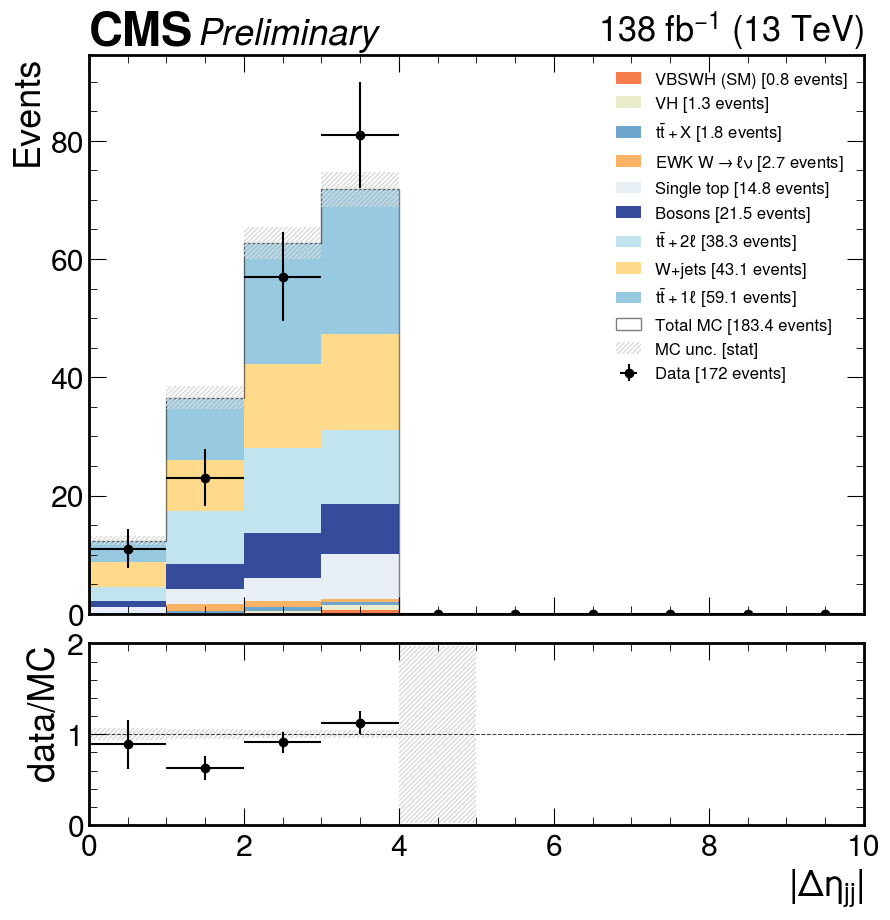

In [13]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "deta_jj", bins=np.linspace(0,10,11), 
        selection=selection,
        transf=abs,
        x_label=r"$|\Delta\eta_{jj}|$",
    #     norm=True,
        stacked=True
    )
    axes.legend(fontsize=12)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/n_fatjets_data_vs_mc_regionA.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/n_fatjets_data_vs_mc_regionB.pdf
Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/n_fatjets_data_vs_mc_regionC.pdf


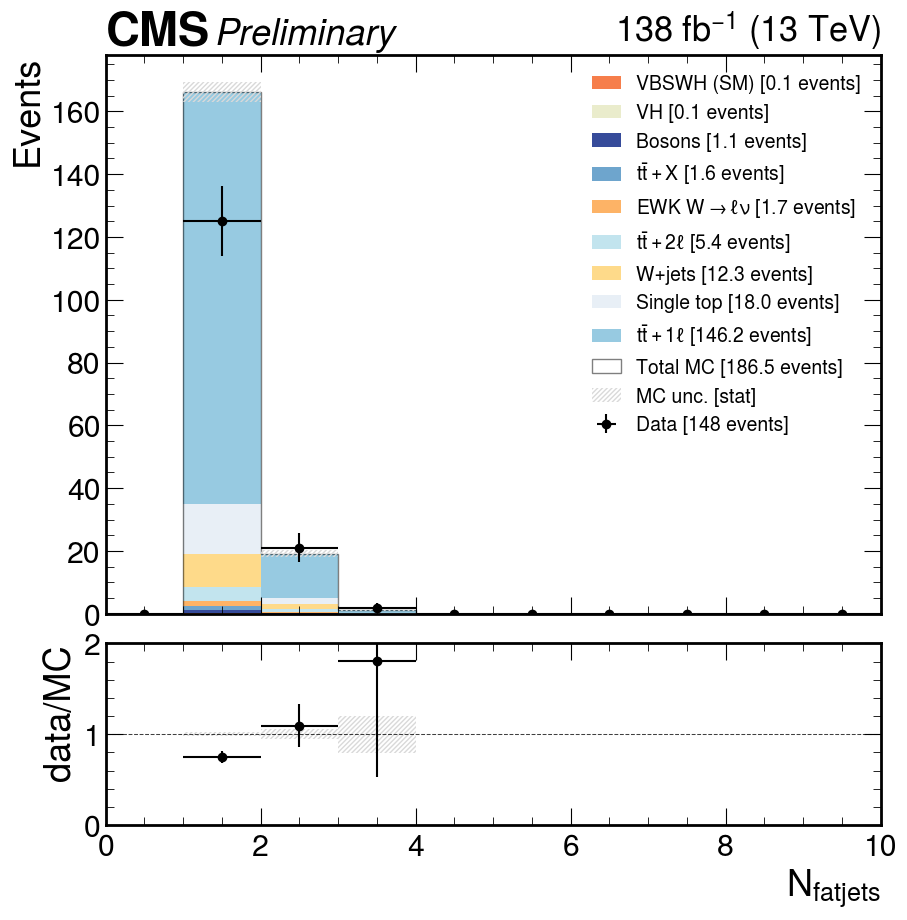

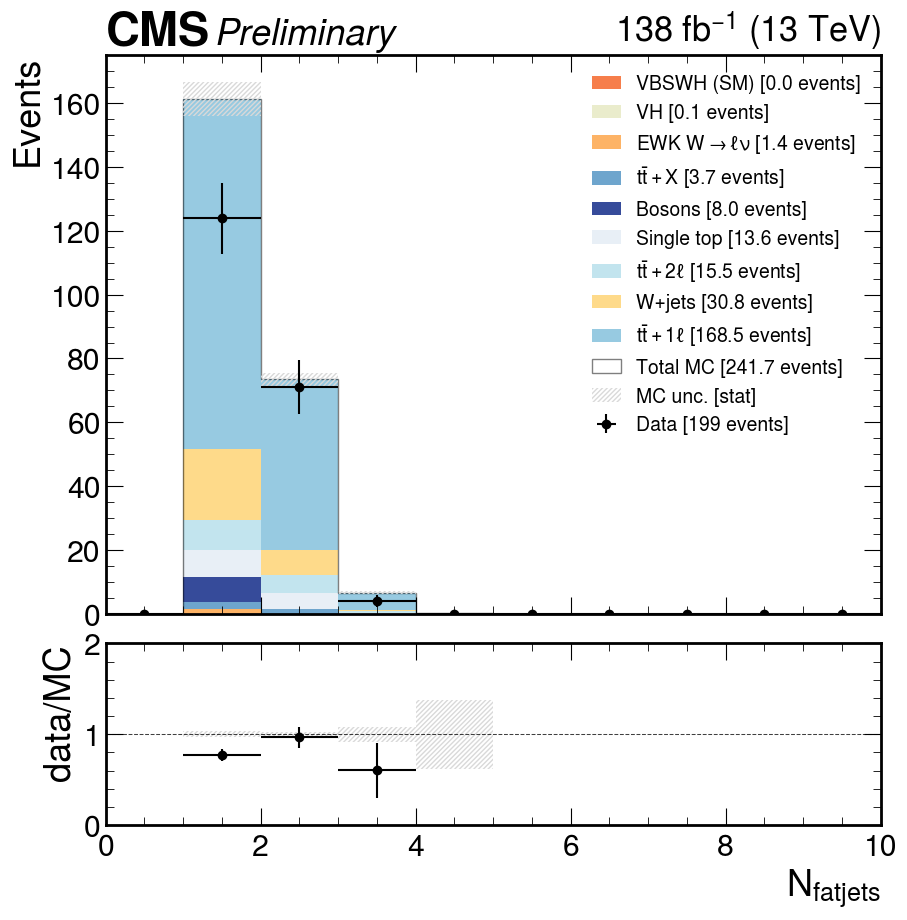

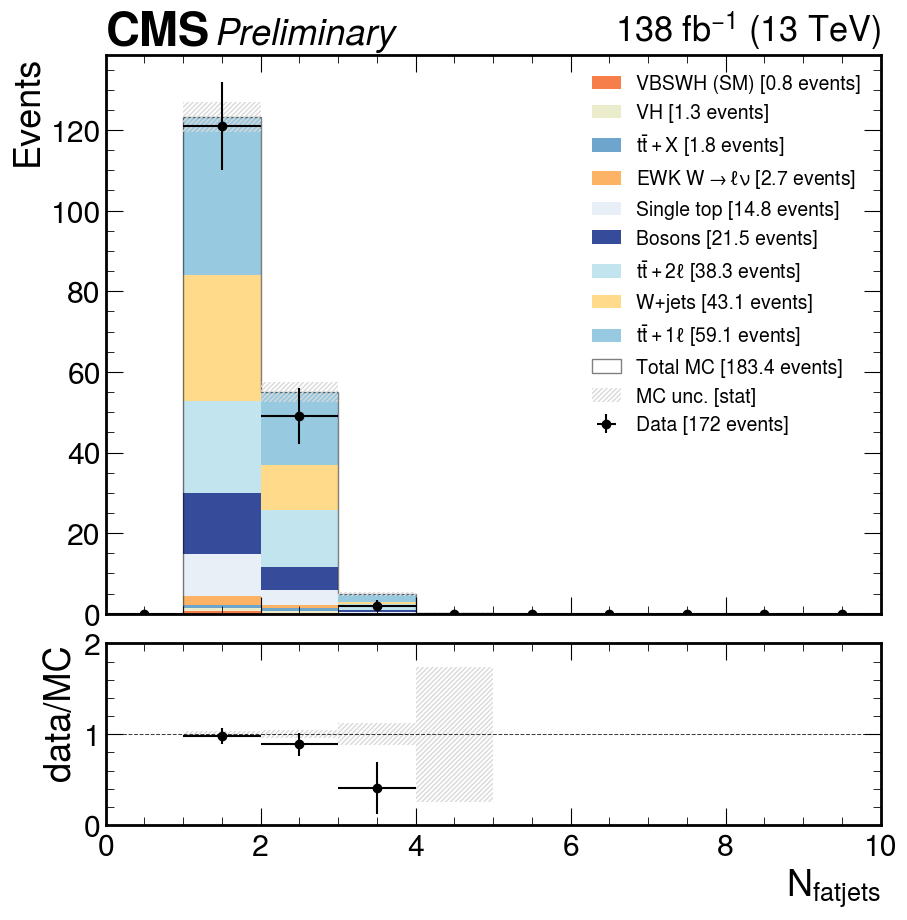

In [14]:
for selection in ["regionA", "regionB", "regionC"]:
    axes, _ = vbswh.plot_data_vs_mc(
        "n_fatjets", bins=np.linspace(0, 10, 11), 
        selection=selection,
        x_label=r"$N_{fatjets}$",
    #     norm=True,
        stacked=True
    )

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


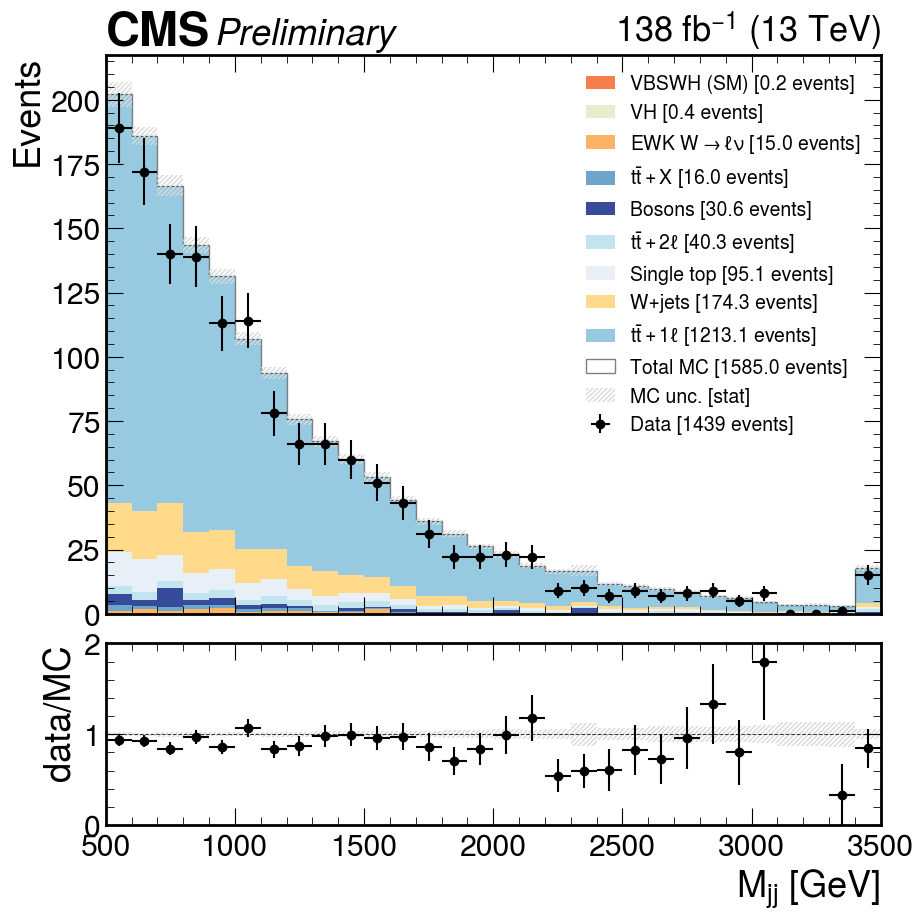

In [15]:
axes, _ = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(500, 3500, 31), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/M_jj_data_vs_mc_presel_noDetaJJ_and_abs(deta_jj)_lt_3.pdf


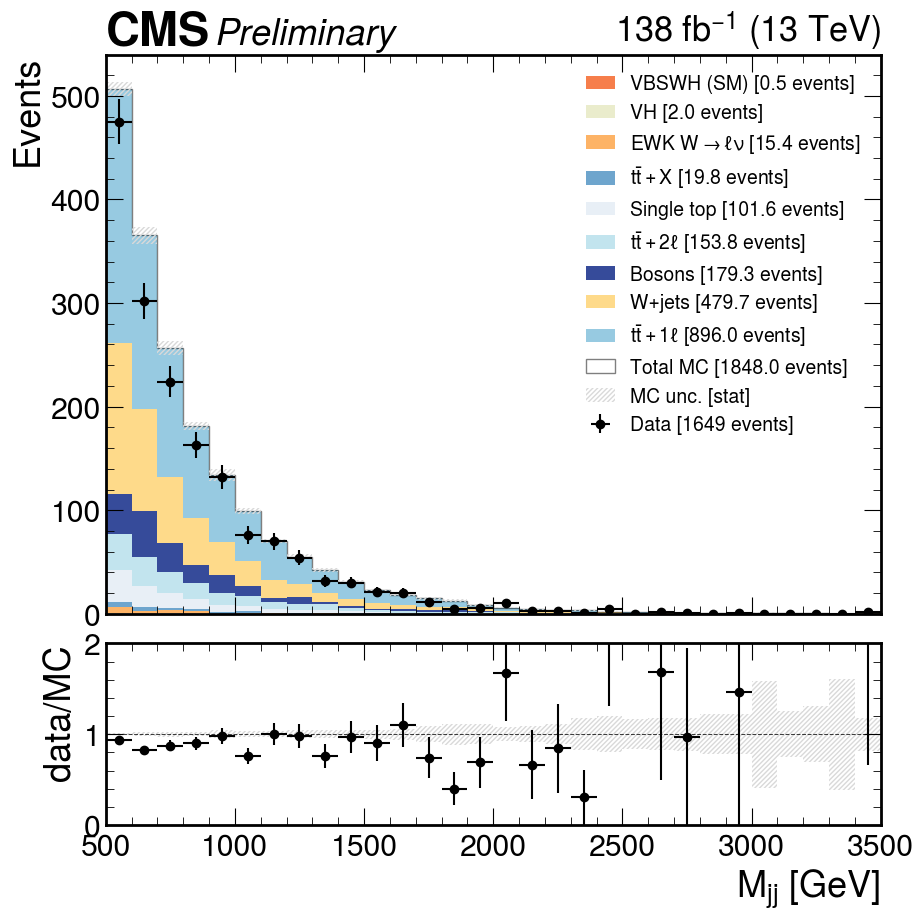

In [16]:
axes, _ = vbswh.plot_data_vs_mc(
    "M_jj", bins=np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ and abs(deta_jj) < 3",
    x_label=r"$M_{jj}$ [GeV]",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/deta_jj_data_vs_mc_presel_noDetaJJ_and_abs(deta_jj)_lt_3.pdf


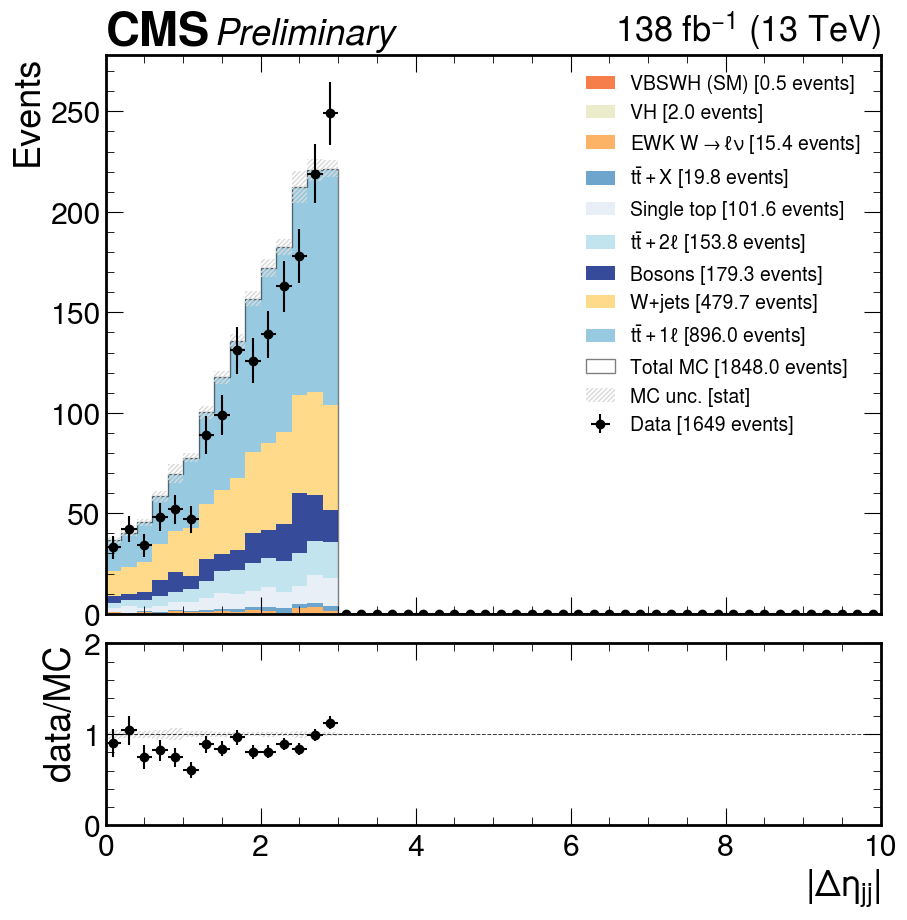

In [17]:
axes, _ = vbswh.plot_data_vs_mc(
    "deta_jj", bins=np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ and abs(deta_jj) < 3",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/deta_jj_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


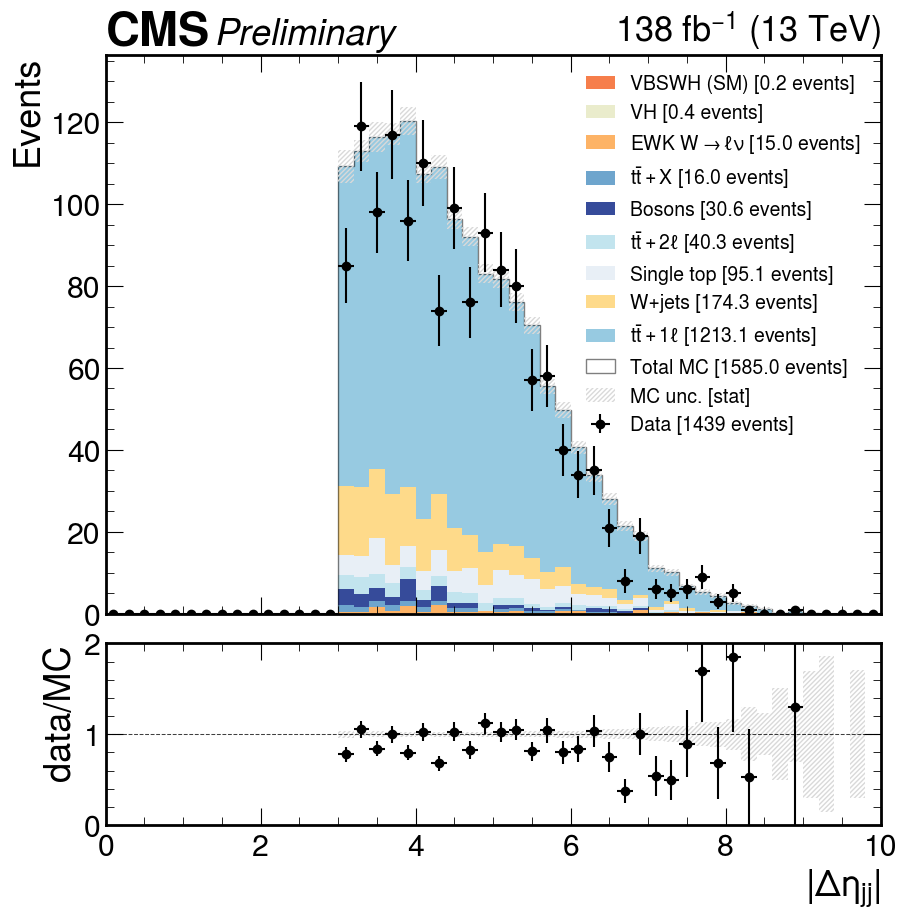

In [18]:
axes, _ = vbswh.plot_data_vs_mc(
    "deta_jj", bins=np.linspace(0,10,51), 
    selection="presel and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_score_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


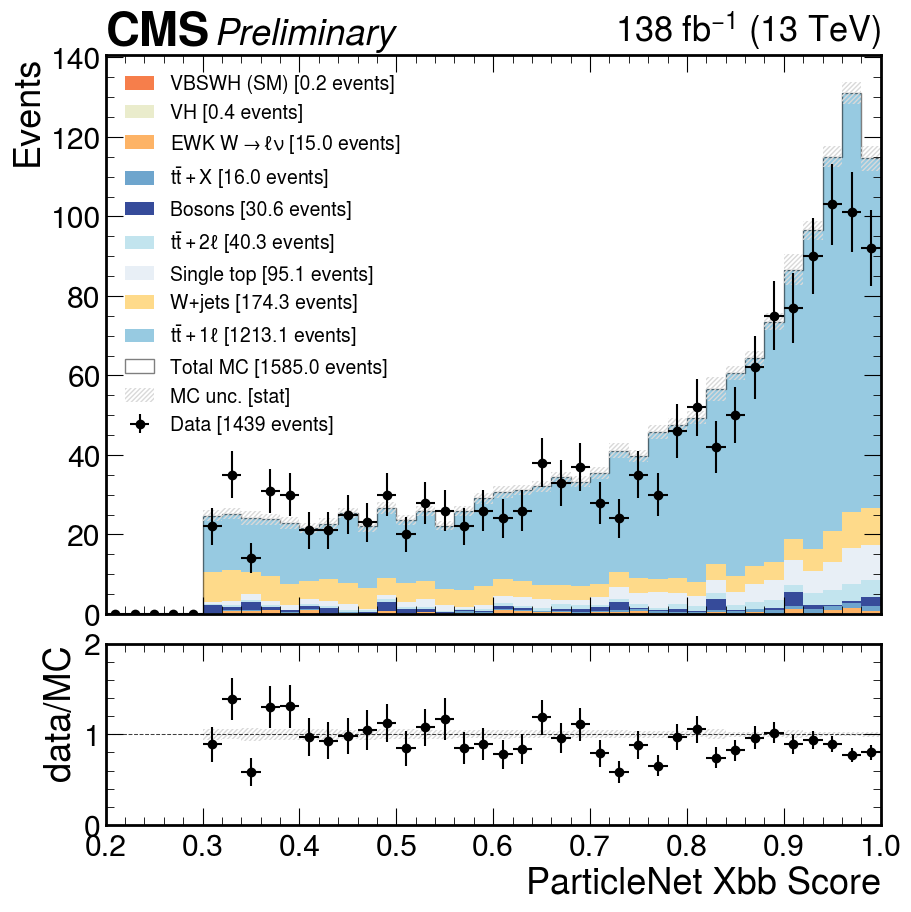

In [19]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", bins=np.linspace(0.2, 1.0, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"ParticleNet Xbb Score",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_msoftdrop_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


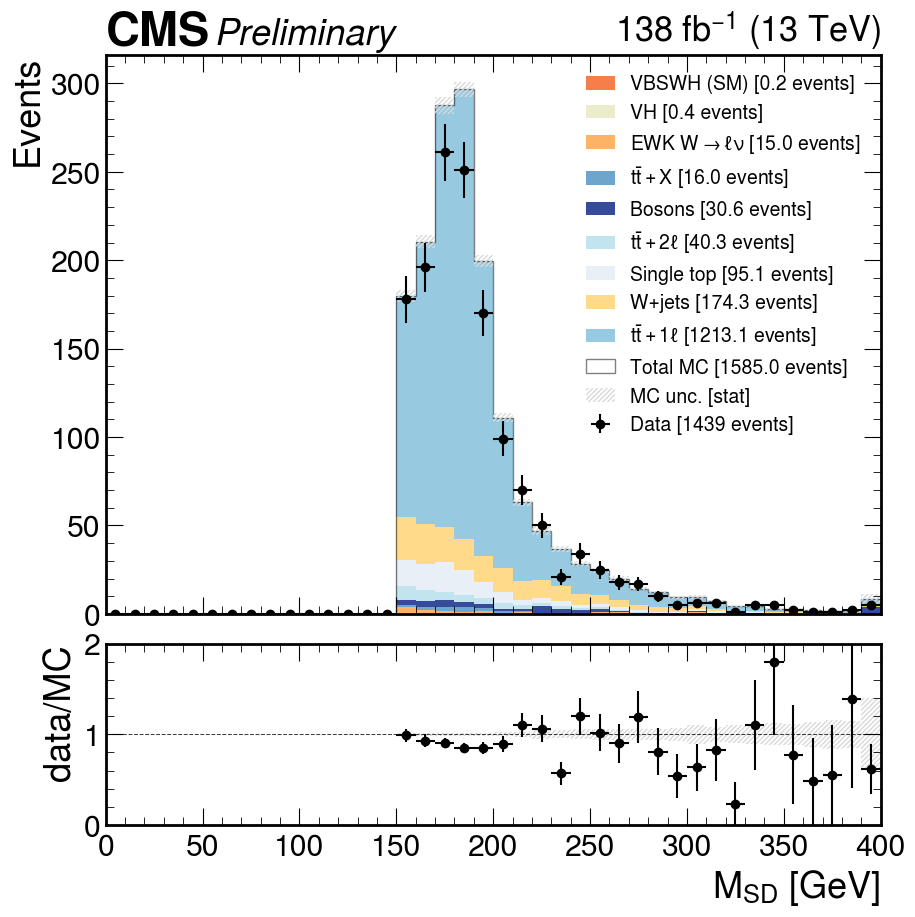

In [20]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", bins=np.linspace(0, 400, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$M_{SD}$ [GeV]",
#     norm=True,
    stacked=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/ST_data_vs_mc_presel_noDetaJJ_and_abs(deta_jj)_leq_3.pdf


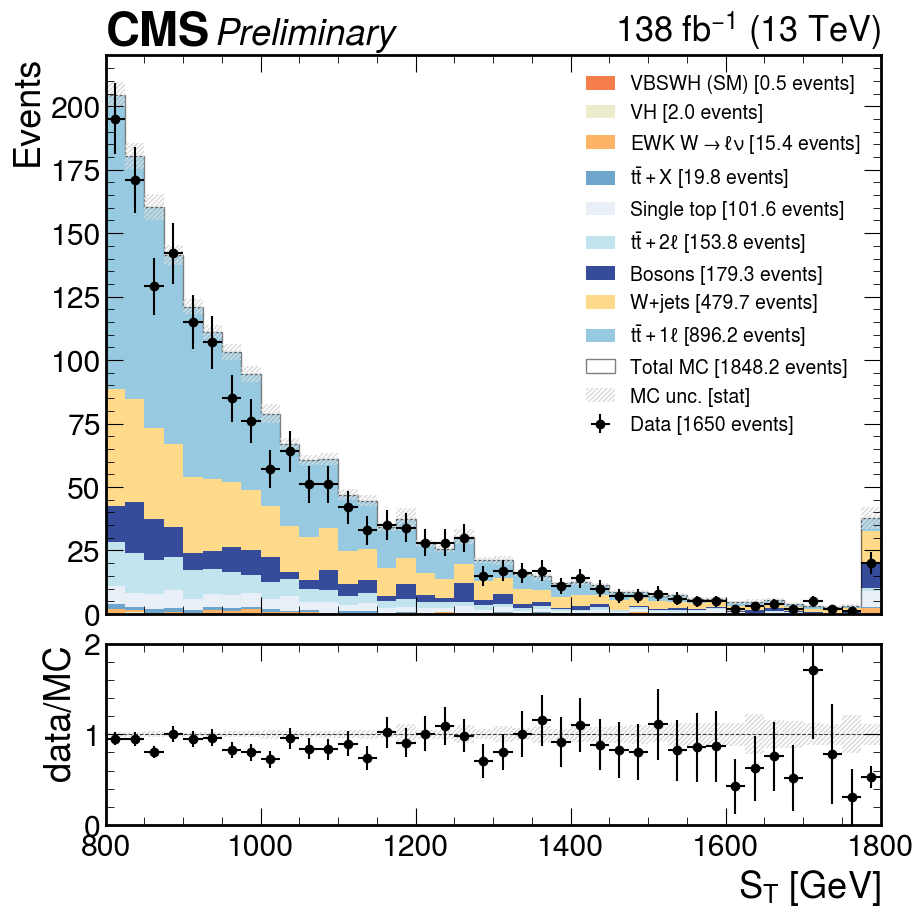

In [21]:
axes, _ = vbswh.plot_data_vs_mc(
    "ST", bins=np.linspace(800, 1800, 41), 
    selection="presel_noDetaJJ and abs(deta_jj) <= 3",
    x_label=r"$S_T$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
)
# axes.set_yscale("log", nonpositive='clip')
# axes.set_ylim(bottom=0.1)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/ST_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150.pdf


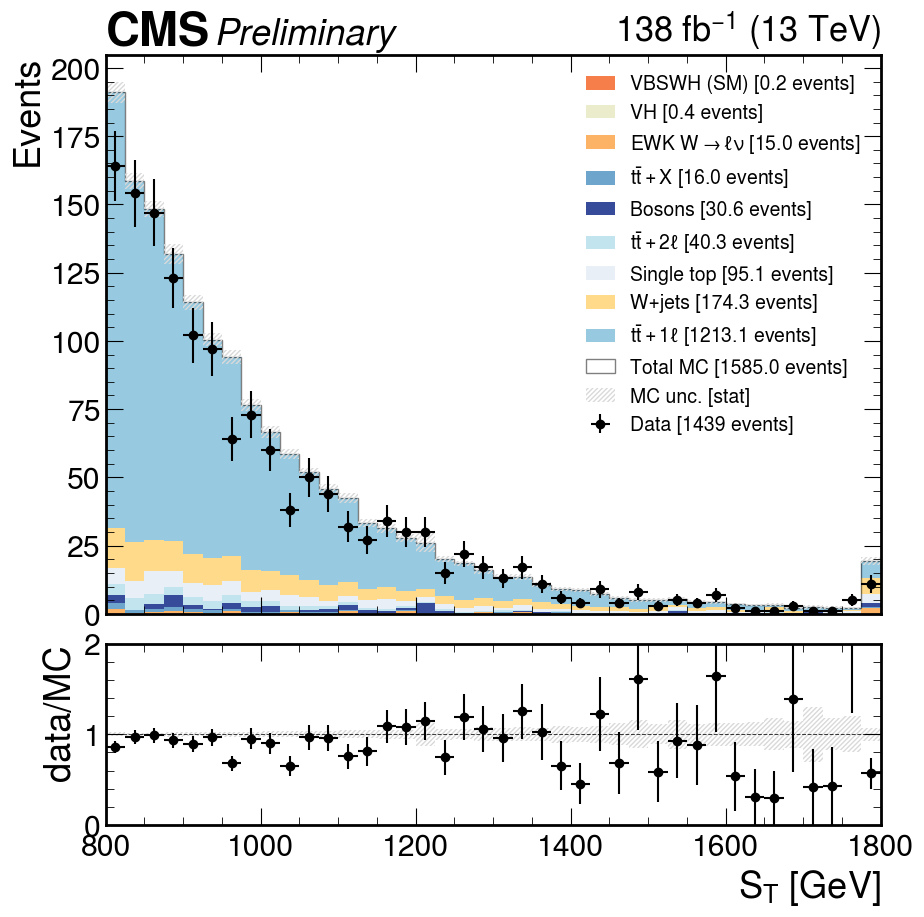

In [22]:
axes, _ = vbswh.plot_data_vs_mc(
    "ST", bins=np.linspace(800, 1800, 41), 
    selection="presel and hbbjet_msoftdrop >= 150",
    x_label=r"$S_T$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
)
# axes.set_yscale("log", nonpositive='clip')
# axes.set_ylim(bottom=0.1)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/lep_pt_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs(deta_jj)_gt_4_and_hbbjet_score_gt_0p9.pdf


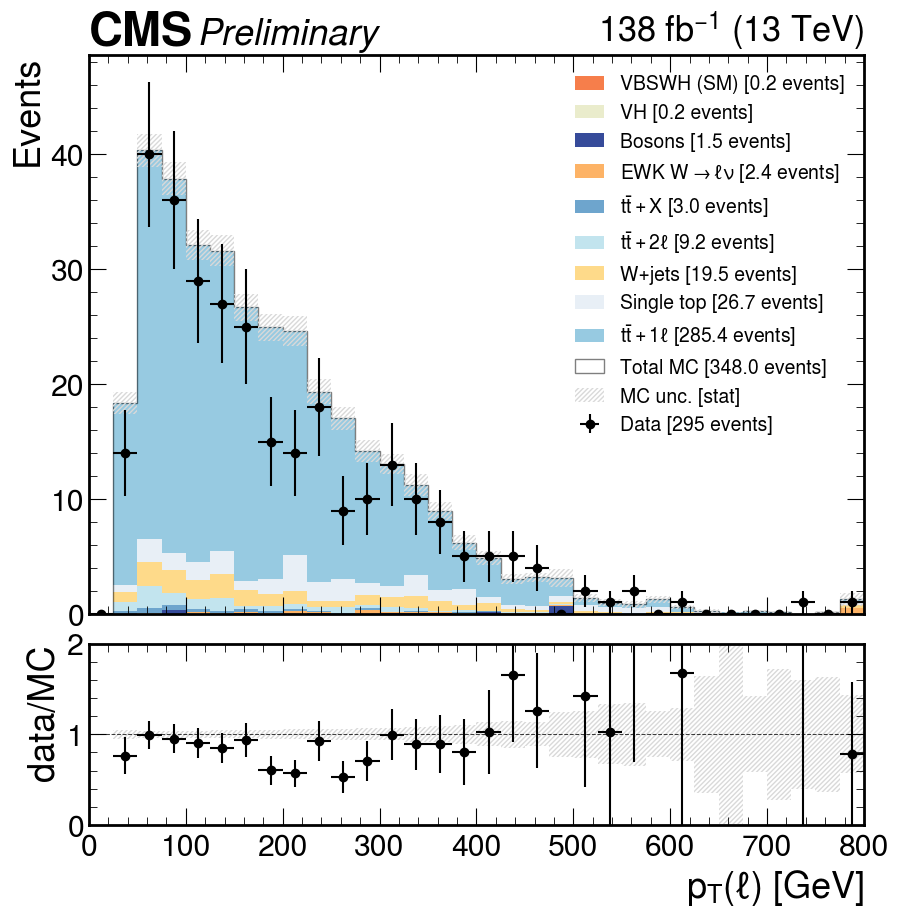

In [23]:
axes, _ = vbswh.plot_data_vs_mc(
    "lep_pt", bins=np.linspace(0, 800, 33), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs(deta_jj) > 4 and hbbjet_score > 0.9",
    x_label=r"$p_T(\ell)$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/MET_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs(deta_jj)_gt_4_and_hbbjet_score_gt_0p9.pdf


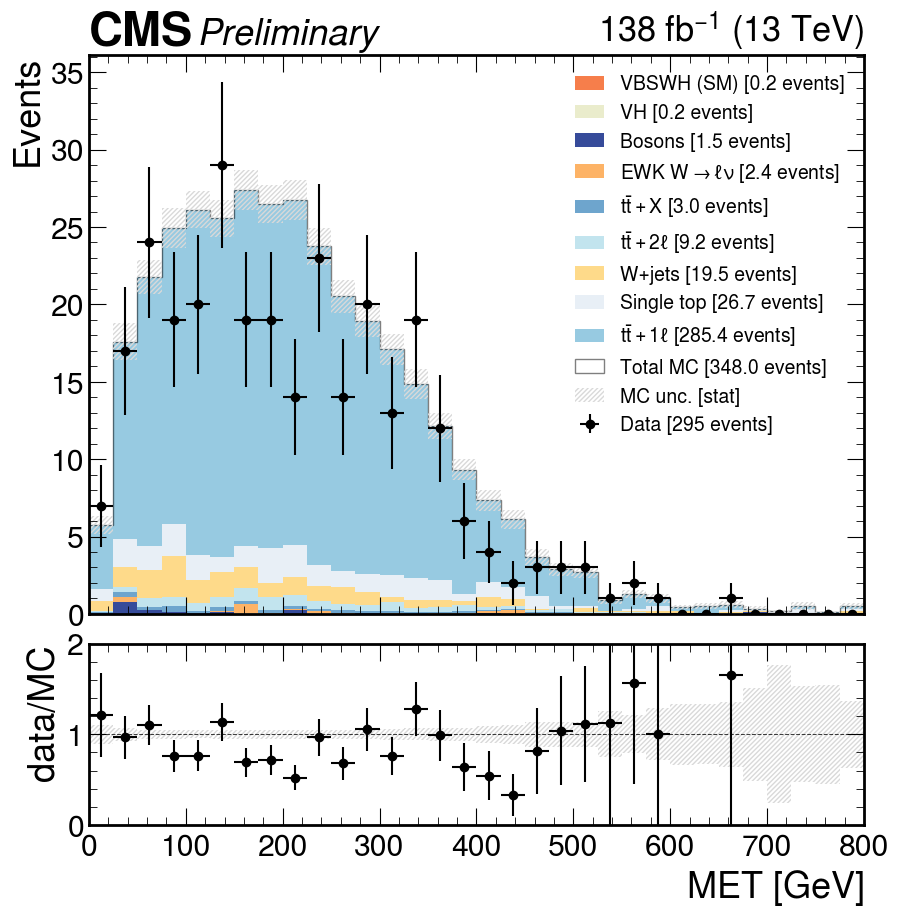

In [24]:
axes, _ = vbswh.plot_data_vs_mc(
    "MET", bins=np.linspace(0, 800, 33), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs(deta_jj) > 4 and hbbjet_score > 0.9",
    x_label=r"$MET$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_phi_data_vs_mc_regionA.pdf


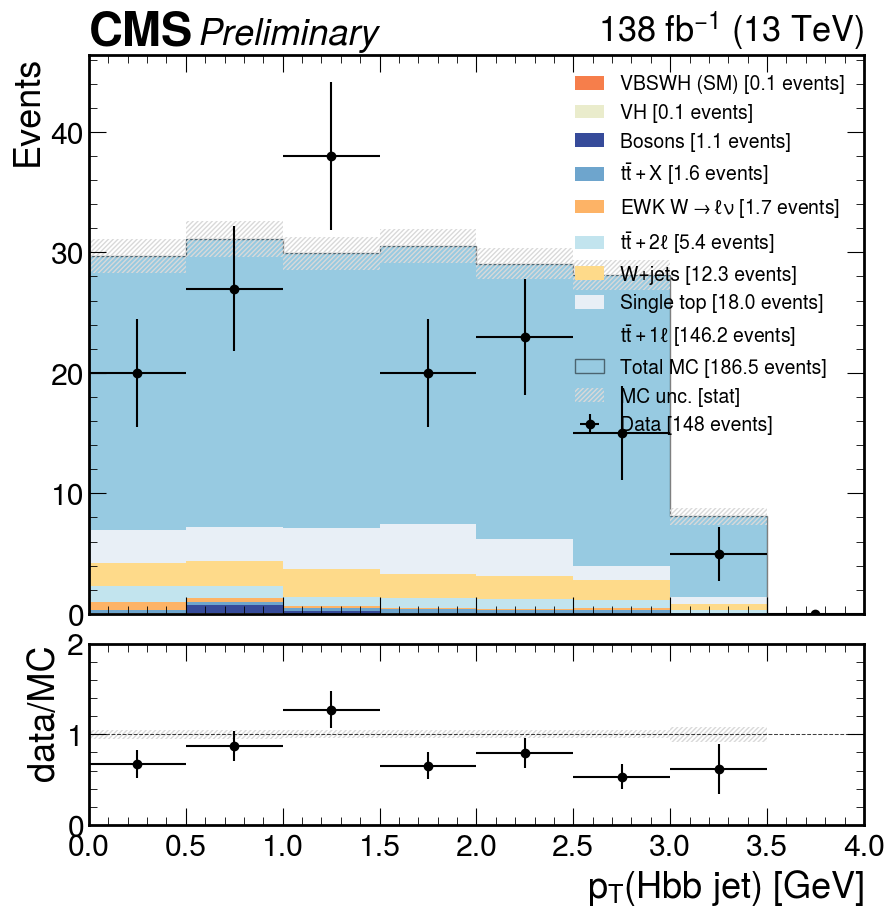

In [25]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_phi", bins=np.linspace(0, 4, 9), 
    selection="regionA",
    x_label=r"$p_T($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
    transf=abs
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_phi_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_hbbjet_score_gt_0p9.pdf


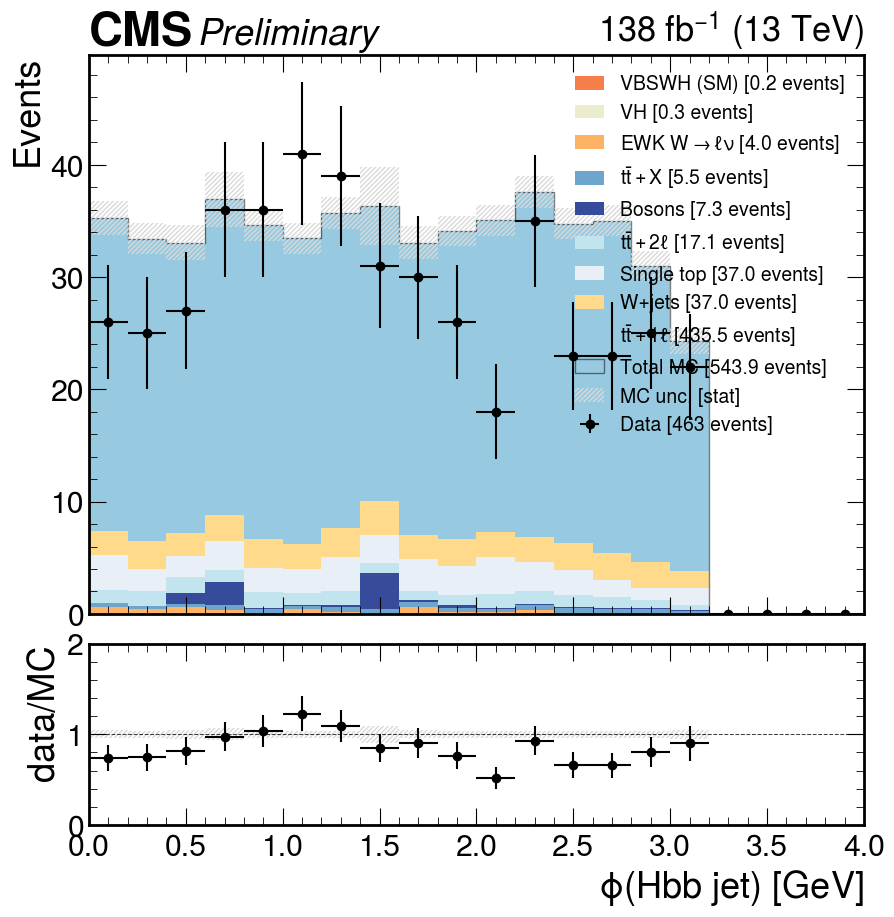

In [26]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_phi", bins=np.linspace(0, 4, 21), 
    selection="presel and hbbjet_msoftdrop >= 150 and hbbjet_score > 0.9",
    x_label=r"$\phi($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
    transf=abs
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_pt_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs(deta_jj)_gt_4_and_hbbjet_score_gt_0p9.pdf


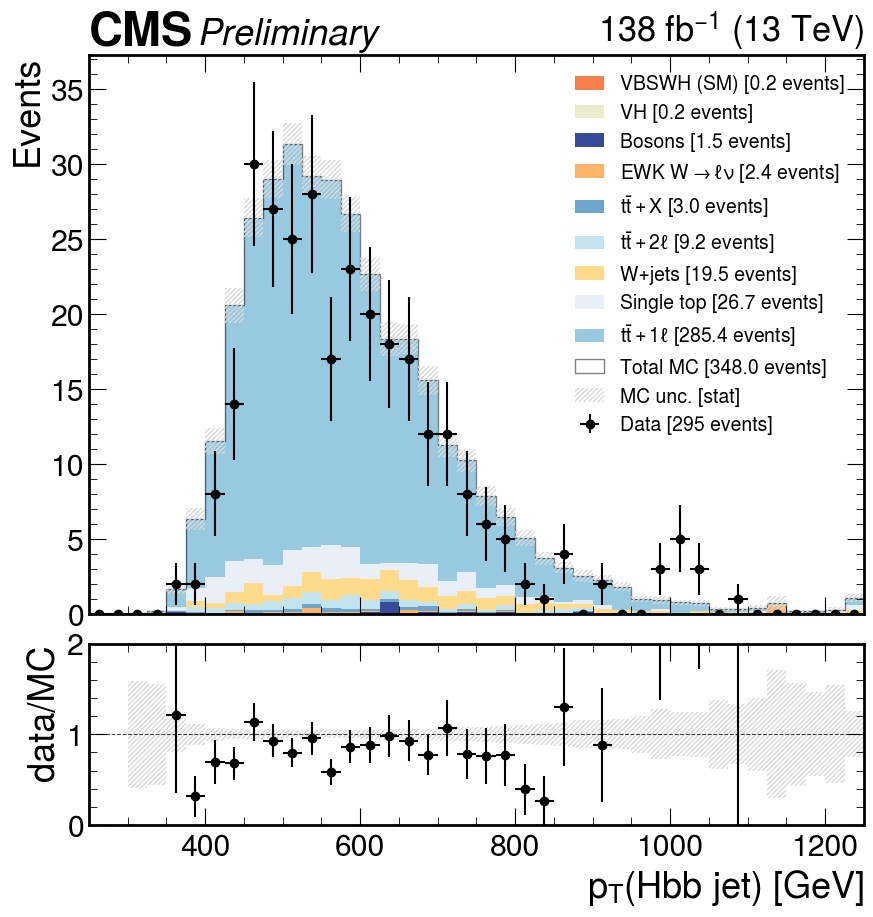

In [27]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_pt", bins=np.linspace(250, 1250, 41), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs(deta_jj) > 4 and hbbjet_score > 0.9",
    x_label=r"$p_T($Hbb jet$)$ [GeV]",
#     norm=True,
    stacked=True,
#     logy=True
)

Wrote plot to /home/users/jguiang/public_html/vbswh_plots/kscans/val/hbbjet_score_data_vs_mc_presel_and_hbbjet_msoftdrop_geq_150_and_abs(deta_jj)_gt_4.pdf


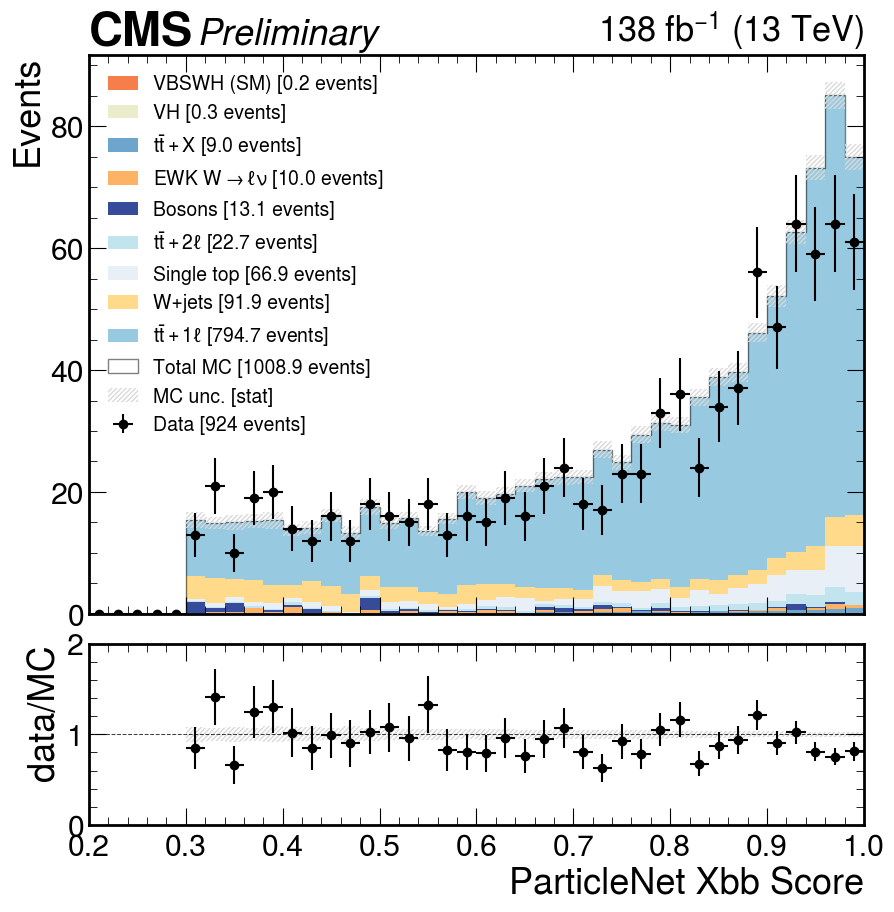

In [28]:
axes, _ = vbswh.plot_data_vs_mc(
    "hbbjet_score", bins=np.linspace(0.2, 1.0, 41), 
    selection="presel and hbbjet_msoftdrop >= 150 and abs(deta_jj) > 4",
    x_label=r"ParticleNet Xbb Score",
#     norm=True,
    stacked=True
)